# VESDE

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Function to generate funnel data
def sample_funnel_data(num_samples=10000):
    z = torch.randn(num_samples) * 0.8
    x = torch.randn(num_samples) * torch.exp(z) / 5
    return torch.stack([x, z], dim=1)

class ScoreModel(nn.Module):
    def __init__(self, hidden_dims=[128, 256, 128], embed_dim=64):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        self.net = nn.ModuleList()
        input_dim = 2
        for h_dim in hidden_dims:
            self.net.append(nn.Sequential(
                nn.Linear(input_dim + embed_dim, h_dim),
                nn.SiLU()
            ))
            input_dim = h_dim
        
        self.out = nn.Linear(input_dim, 2)

    def forward(self, x, t):
        t_embed = self.embed(t)
        for layer in self.net:
            x = layer(torch.cat([x, t_embed], dim=1))
        return self.out(x)

# Training parameters
sigma_min, sigma_max = 0.01, 50.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ScoreModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Prepare data
data = sample_funnel_data(100000)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Training loop
for epoch in tqdm(range(200)):
    total_loss = 0.0
    for batch, in dataloader:
        x0 = batch.to(device)
        batch_size = x0.size(0)
        
        # Sample time and noise
        t = torch.rand(batch_size, 1, device=device)
        epsilon = torch.randn_like(x0, device=device)
        
        # Compute sigma(t)
        sigma_t = sigma_min * (sigma_max / sigma_min) ** t
        
        # Perturb data
        x_t = x0 + sigma_t * epsilon
        
        # Predict noise
        noise_pred = model(x_t, t)
        
        # Compute loss
        loss = torch.mean((noise_pred - epsilon) ** 2)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(data):.5f}")


 10%|████████████████████▍                                                                                                                                                                                       | 20/200 [00:09<01:23,  2.15it/s]

Epoch 20, Loss: 0.44083


 20%|████████████████████████████████████████▊                                                                                                                                                                   | 40/200 [00:18<01:14,  2.15it/s]

Epoch 40, Loss: 0.43560


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                              | 60/200 [00:27<01:08,  2.06it/s]

Epoch 60, Loss: 0.43951


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 80/200 [00:37<00:56,  2.12it/s]

Epoch 80, Loss: 0.43529


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 100/200 [00:45<00:48,  2.08it/s]

Epoch 100, Loss: 0.43487


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 120/200 [00:55<00:39,  2.04it/s]

Epoch 120, Loss: 0.43590


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 140/200 [01:04<00:27,  2.17it/s]

Epoch 140, Loss: 0.43435


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 160/200 [01:13<00:18,  2.19it/s]

Epoch 160, Loss: 0.43305


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 180/200 [01:22<00:09,  2.17it/s]

Epoch 180, Loss: 0.43630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.19it/s]

Epoch 200, Loss: 0.43209


TypeError: log(): argument 'input' (position 1) must be Tensor, not float

In [75]:
from matplotlib.animation import FuncAnimation, PillowWriter

def make_animation(trajectory, filename="sampling.gif"):
    """
    Given a list of [N x 2] arrays (trajectory), create and save an animation.
    """
    trajectory = [x.cpu() for x in trajectory]
    fig, ax = plt.subplots(figsize=(5, 5))
    scat = ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='red',s=0.2)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.axis("off")
    ax.set_aspect('equal')
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, fontsize=12)

    def update(frame):
        data = trajectory[frame]
        scat.set_offsets(data)
        time_text.set_text(f"Step {frame}/{len(trajectory)-1}")
        return scat, time_text

    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=1)
    writer = PillowWriter(fps=40)
    ani.save(filename, writer=writer)
    plt.close()

# SDE sampling

In [15]:
sigma_min, sigma_max = 0.01, 50.0

In [27]:
import numpy as np
def sigma_t_fn(t):
    return sigma_min * math.pow(sigma_max/sigma_min,t)

In [28]:
ts = np.linspace(0,1,1000)
ys = [sigma_t_fn(t) for t in ts]

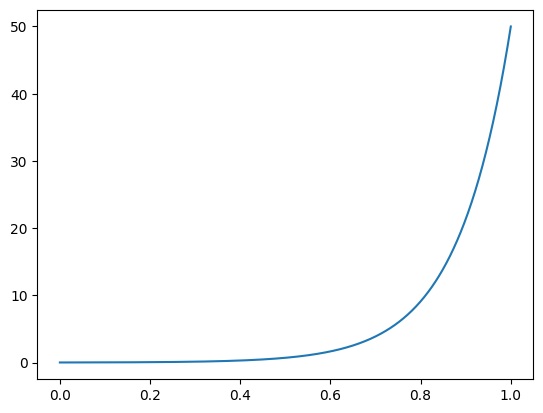

In [29]:
plt.plot(ts,ys)

In [30]:
min(ys)

0.01

In [31]:
def d_sigma2_dt_fn(t):
    sigma_devide = (sigma_max / sigma_min)
    sigma_t = sigma_min * math.pow(sigma_devide,t)
        
    d_sigma2_dt = 2*sigma_t**2 * math.log(sigma_devide)
    return d_sigma2_dt

In [32]:
yys = [d_sigma2_dt_fn(t) for t in ts]

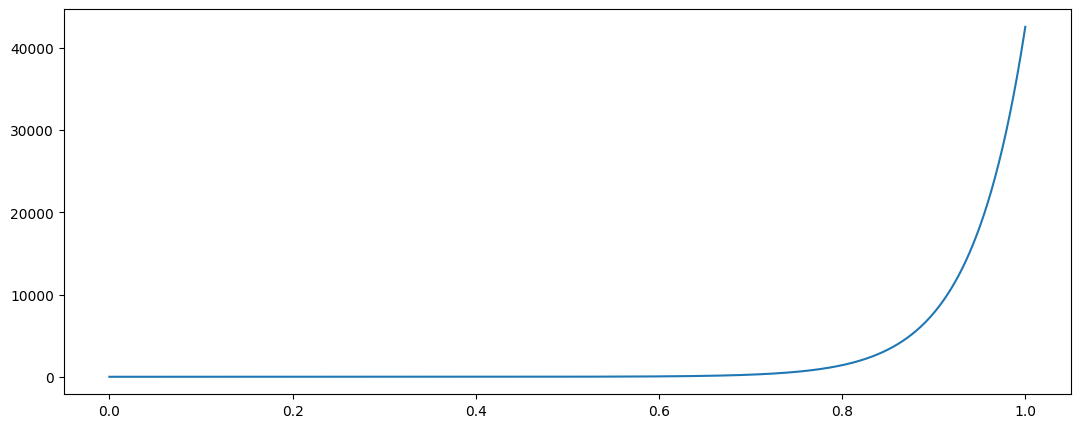

In [35]:
plt.figure(figsize=(13,5))
plt.plot(ts,yys)

In [36]:
min(yys)

0.0017034386382832477

In [42]:
model  = model.eval()

In [ ]:
sigma_t = sigma_min * math.pow(sigma_devide,t)

In [44]:
device ='cpu'

In [45]:
model = model.to(device)

In [67]:

# Reverse process sampling
def sample_reverse_process(model, num_samples=1000, steps=1500):
    model.eval()
    x_t = torch.randn(num_samples, 2, device=device) * sigma_max
    trajectory = [x_t.cpu().detach()]
    dt = 1.0 / steps
    print('steps',steps)
    for i in range(steps, 0, -1):
        print('i',i,end="\r")
        t = torch.full((num_samples, 1), i / steps, device=device)
        t_scala =  i / steps
        sigma_devide = (sigma_max / sigma_min)
        sigma_t = sigma_min * math.pow(sigma_devide,t_scala)
        
        d_sigma2_dt = 2*sigma_t**2 * math.log(sigma_devide)
        with torch.no_grad():
            noise_pred = model(x_t, t)
        score = - noise_pred/sigma_t

        # Reverse step
        x_t = x_t +  d_sigma2_dt * score*dt - math.sqrt(d_sigma2_dt)*torch.randn_like(x_t)*math.sqrt(dt)
        trajectory.append(x_t.cpu().detach())
    
    return x_t.cpu().detach(), trajectory

# Flow ODE sampling
def sample_flow_ode(model, num_samples=1000, steps=1500):
    model.eval()
    x_t = torch.randn(num_samples, 2, device=device) * sigma_max
    trajectory = [x_t.cpu().detach()]
    dt = -1.0 / steps
    
    for i in range(steps):
        t = torch.full((num_samples, 1), i / steps, device=device)
        sigma_t = sigma_min * (sigma_max / sigma_min) ** t
        d_sigma2_dt = sigma_t**2 * math.log(sigma_max**2 / sigma_min**2)
        noise_pred = model(x_t, t)
        score = - noise_pred/sigma_t
        x_t = x_t -  d_sigma2_dt * score*dt
        trajectory.append(x_t.cpu().detach())
    
    return x_t.cpu().detach(), trajectory

# DDIM sampling
def sample_ddim(model, num_samples=1000, steps=50, eta=0.0):
    model.eval()
    x_t = torch.randn(num_samples, 2, device=device) * sigma_max
    trajectory = [x_t.cpu().detach()]
    
    for i in range(steps, 0, -1):
        t = torch.full((num_samples, 1), i / steps, device=device)
        sigma_t = sigma_min * (sigma_max / sigma_min) ** t
        d_sigma2_dt = sigma_t**2 * math.log(sigma_max**2 / sigma_min**2)
        noise_pred = model(x_t, t)
        x_t = x_t - (1 - eta) * (noise_pred / sigma_t) * d_sigma2_dt
        trajectory.append(x_t.cpu().detach())
    
    return x_t.cpu().detach(), trajectory

#

In [ ]:
Generate samples and trajectories
final_samples_sde, trajectory_sdem = sample_reverse_process(model, num_samples=10000, steps=1500)

# final_samples_ode, trajectory_ode = sample_flow_ode(model, num_samples=1500, steps=1500)
# final_samples_ddim, trajectory_ddim = sample_ddim(model, num_samples=1000, steps=1500)

# Plot final distributions
plot_final_distribution(final_samples_sde)
# plot_final_distribution(final_samples_ddim)


In [73]:
# img_file='/mnt/nas/public2/lilong/repos/generative-ai-start-to-surrender/docs/images/ve_sde.gif'
# make_animation(trajectory_sdem, filename=img_file)

In [88]:
trajectory_sdem[0][:,0].min(),trajectory_sdem[0][:,0].max(),trajectory_sdem[0][:,1].min(),trajectory_sdem[0][:,1].max()

(tensor(-175.7742), tensor(186.9791), tensor(-182.8667), tensor(189.8134))

In [92]:

img_file='/mnt/nas/public2/lilong/repos/generative-ai-start-to-surrender/docs/images/ve_sde.gif'
make_animation_v2(trajectory_sdem, filename=img_file)

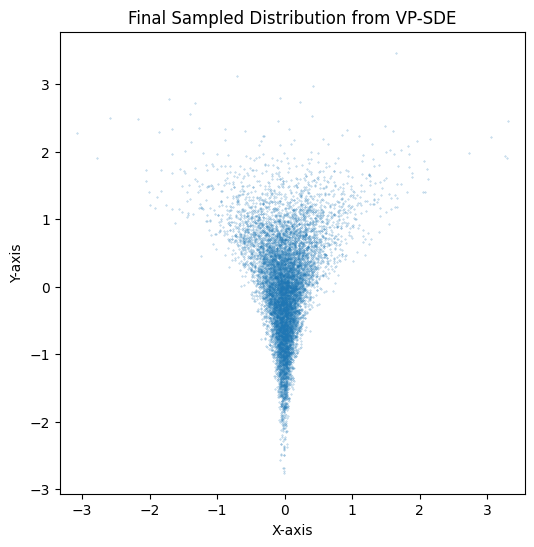

In [64]:
# Plot final distribution
plt.figure(figsize=(6, 6))
plt.scatter(final_samples_sde[:, 0], final_samples_sde[:, 1], alpha=0.5, s=0.1)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 
plt.show()

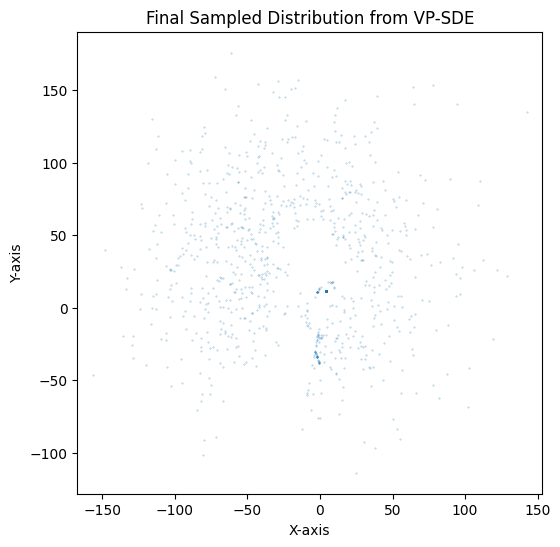

In [66]:
# Plot final distribution
plt.figure(figsize=(6, 6))
plt.scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], alpha=0.5, s=0.1)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 
plt.show()

In [54]:
final_samples_sde

tensor([[ -541.8528,   221.7794],
        [ 5393.5181, -2955.3306],
        [-1773.9956, -1142.5264],
        ...,
        [  484.2148,   301.3806],
        [  277.7639,  1269.9427],
        [  534.3377,   244.6602]])

In [62]:
from matplotlib.animation import FuncAnimation, PillowWriter

def make_animation(trajectory, filename="sampling.gif"):
    """
    Given a list of [N x 2] arrays (trajectory), create and save an animation.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    scat = ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='red',s=0.2)
    # ax.set_xlim(-6, 6)
    # ax.set_ylim(-6, 6)
    # ax.axis("off")
    ax.set_aspect('equal')
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, fontsize=12)

    def update(frame):
        data = trajectory[frame]
        scat.set_offsets(data)
        time_text.set_text(f"Step {frame}/{len(trajectory)-1}")
        return scat, time_text

    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=1)
    writer = PillowWriter(fps=40)
    ani.save(filename, writer=writer)
    plt.close()

In [91]:

# Animation function with main and inset plot
def make_animation_v2(trajectory, filename="sampling.gif"):
    """
    Create and save an animation with both a main plot (fixed limits) and an inset plot (dynamic limits).
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    inset_ax = fig.add_axes([0.65, 0.65, 0.25, 0.25])  # Small inset plot in upper right corner
    
    scat = ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='red', s=0.2)
    inset_scat = inset_ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='blue', s=0.2)
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.axis("off")
    ax.set_aspect('equal')
    inset_ax.axis("on")
    inset_ax.set_xlim(trajectory[0][:, 0].min(), trajectory[0][:, 0].max())
    inset_ax.set_ylim(trajectory[0][:, 1].min(), trajectory[0][:, 1].max())
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, fontsize=12)
    
    def update(frame):
        data = trajectory[frame]
        scat.set_offsets(data)
        inset_scat.set_offsets(data)
        

        time_text.set_text(f"Step {frame}/{len(trajectory)-1}")
        return scat, inset_scat, time_text
    
    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=1)
    writer = PillowWriter(fps=40)
    ani.save(filename, writer=writer)
    plt.close()

In [144]:
t = torch.rand(1024, 1, device=device)
epsilon = torch.randn_like(x0, device=device)

# 计算 α(t) 和 σ(t)
integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
alpha = torch.exp(-0.5 * integral)
sigma = torch.sqrt(1.0 - alpha**2)
print(min(alpha))

tensor([0.0066], device='cuda:0')


(array([173., 112.,  94.,  72.,  63.,  67.,  59.,  84., 110., 190.]),
 array([0.08124758, 0.17311963, 0.2649917 , 0.35686374, 0.4487358 ,
        0.54060787, 0.63247991, 0.72435194, 0.81622398, 0.90809608,
        0.99996811]),
 <BarContainer object of 10 artists>)

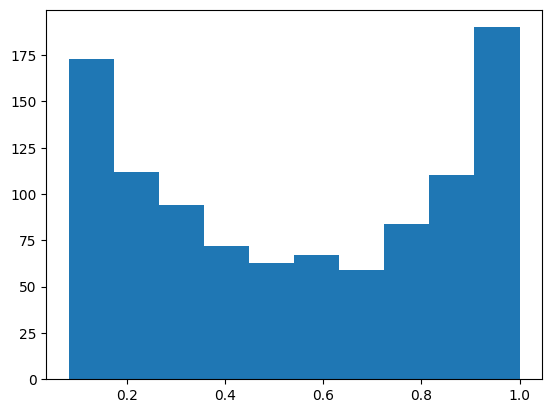

In [135]:
plt.hist(torch.sqrt(alpha).cpu().numpy())

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Function to generate funnel data
def sample_funnel_data(num_samples=10000):
    z = torch.randn(num_samples) * 0.8
    x = torch.randn(num_samples) * torch.exp(z) / 5
    return torch.stack([x, z], dim=1)

class ScoreModel(nn.Module):
    def __init__(self, hidden_dims=[128, 256, 128], embed_dim=64):
        super().__init__()
        # 时间嵌入层
        self.embed = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        # 主干网络
        self.net = nn.ModuleList()
        input_dim = 2  # 输入维度
        for h_dim in hidden_dims:
            self.net.append(nn.Sequential(
                nn.Linear(input_dim + embed_dim, h_dim),
                nn.SiLU()))
            input_dim = h_dim
        self.out = nn.Linear(input_dim, 2)  # 输出噪声预测
    
    def forward(self, x, t):
        t_embed = self.embed(t)
        for layer in self.net:
            x = layer(torch.cat([x, t_embed], dim=1))
        return self.out(x)

# 训练参数
beta_min, beta_max = 0.1, 20.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
model = ScoreModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# 准备数据
data = sample_funnel_data(100000)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)


from tqdm import tqdm
# 训练循环
for epoch in tqdm(range(200)):
    total_loss = 0.0
    for batch, in dataloader:
        x0 = batch.to(device)
        batch_size = x0.size(0)
        
        # 采样时间和噪声
        t = torch.rand(batch_size, 1, device=device)
        epsilon = torch.randn_like(x0, device=device)
        
        # 计算 α(t) 和 σ(t)
        integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
        alpha = torch.exp(-integral)
        sigma = torch.sqrt(1.0 - alpha)
        
        # 扰动数据
        x_t = torch.sqrt(alpha) * x0 + torch.sqrt(1.0 - alpha) * epsilon
        
        # 预测噪声
        score_pred = model(x_t, t)
        
        # 计算加权损失
        # beta_t = beta_min + (beta_max - beta_min) * t
        # print((1-alpha))
        loss = torch.mean( (score_pred - epsilon)**2) # predict is the score
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(data):.5f}")

 10%|████████████████████▍                                                                                                                                                                                       | 20/200 [00:09<01:22,  2.18it/s]

Epoch 20, Loss: 0.17275


 20%|████████████████████████████████████████▊                                                                                                                                                                   | 40/200 [00:18<01:12,  2.20it/s]

Epoch 40, Loss: 0.17296


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                              | 60/200 [00:28<01:00,  2.32it/s]

Epoch 60, Loss: 0.17241


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 80/200 [00:37<00:54,  2.21it/s]

Epoch 80, Loss: 0.17187


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 100/200 [00:46<00:44,  2.26it/s]

Epoch 100, Loss: 0.17155


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 120/200 [00:55<00:34,  2.29it/s]

Epoch 120, Loss: 0.16966


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 140/200 [01:04<00:24,  2.41it/s]

Epoch 140, Loss: 0.17270


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 160/200 [01:13<00:20,  1.92it/s]

Epoch 160, Loss: 0.17075


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 180/200 [01:23<00:08,  2.29it/s]

Epoch 180, Loss: 0.17171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:32<00:00,  2.16it/s]

Epoch 200, Loss: 0.16930


In [166]:
data.shape

torch.Size([100000, 2])

(-7.0, 7.0)

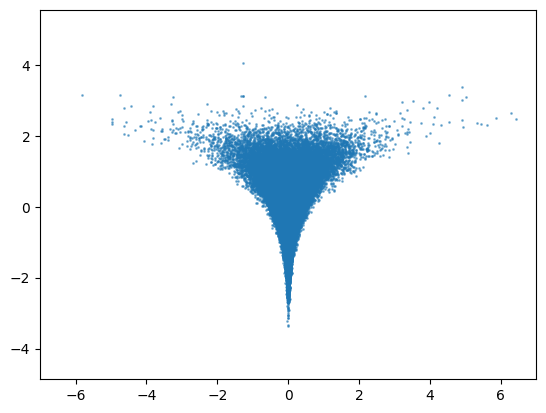

In [169]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=1)
plt.axis("equal") 
plt.xlim(-7,7)

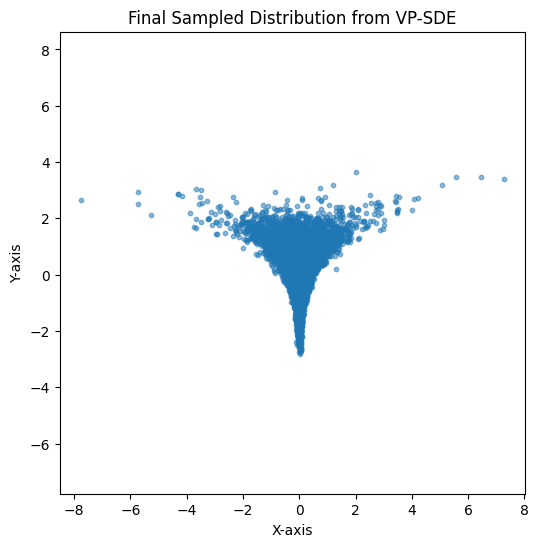

In [172]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

def vp_sde_sample(model,x_T, timesteps, beta_min=0.1, beta_max=20.0, save_trajectory=True):
    """
    Implements the reverse sampling process for VP-SDE using Euler-Maruyama method.
    
    Args:
        x_T: Final noisy sample (torch.Tensor) of shape (N, D)
        timesteps: Number of diffusion steps (int)
        beta_min: Minimum beta value (float)
        beta_max: Maximum beta value (float)
        save_trajectory: Whether to save and return the sampling trajectory (bool)
    
    Returns:
        x_0: Recovered data sample (torch.Tensor)
        trajectory: List of intermediate states (if save_trajectory=True)
    """
    dt = 1.0 / timesteps  # Time step for numerical integration
    x_t = x_T.clone()
    trajectory = [x_t.clone().cpu().numpy()] if save_trajectory else None
    model  = model.eval()
    for t_index in reversed(range(1,timesteps)):
        t = t_index * dt
        print("t",t, end="\r")
        # 计算 α(t) 和 σ(t)
        integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
        integral = torch.Tensor([integral])
        alpha = torch.exp(-integral)
        
        beta_t = beta_min +  (beta_max - beta_min) * t
        beta_t = torch.Tensor([beta_t])
        
        with torch.no_grad():
            t_input = torch.Tensor([t]*len(x_t)).to(device).unsqueeze(-1)
            # print('x_t',x_t.shape, t_input.shape)
            noise_pred = model(x_t.to(device),t_input)
            if  not torch.isfinite(noise_pred).all():
                print('score_function got nan',score_function,t_index)
                raise 
            score_function = - noise_pred.cpu() / torch.sqrt(1-alpha)
        s_theta  = score_function.cpu()
        # Reverse SDE Euler-Maruyama step
        x_t = x_t +1/2 * beta_t *( x_t +2* s_theta)* dt # dritf term            
        x_t += torch.sqrt(beta_t) * torch.randn_like(x_t) * math.sqrt(dt) # diffusion term
        if  not torch.isfinite(x_t).all():
            print("xt got infinite", t_index, x_t[:2],torch.sqrt(1-alpha))
            
        if save_trajectory:
            trajectory.append(x_t.clone().cpu().numpy())

    return x_t, trajectory if save_trajectory else None

# Set parameters
timesteps = 1500
num_samples = 20000
dim = 2  # 2D distribution for visualization
x_T = torch.randn(num_samples, dim)  # Sample from Gaussian prior (standard normal)

# Perform VP-SDE sampling
x_0, trajectory = vp_sde_sample(model, x_T, timesteps)

# Convert trajectory to numpy for plotting
trajectory_np = np.array(trajectory)  # Shape: (timesteps, num_samples, dim)

# Plot final distribution shape
plt.figure(figsize=(6, 6))
plt.scatter(x_0[:, 0].numpy(), x_0[:, 1].numpy(), alpha=0.5, s=10)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 

plt.show()



In [179]:
make_animation(trajectory_np, filename="vp_sde_sampling.gif")

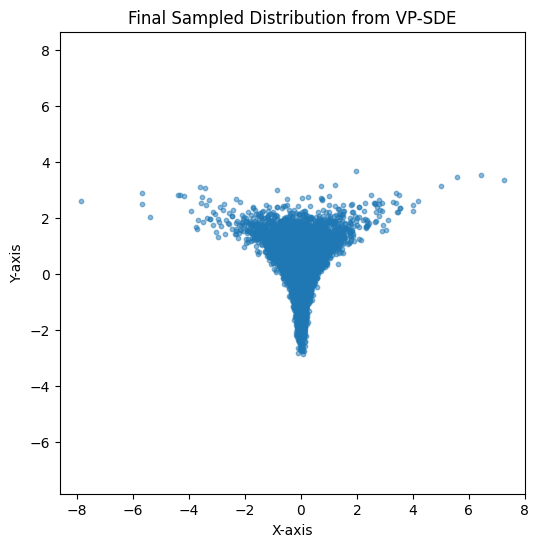

In [178]:
plt.figure(figsize=(6, 6))
plt.scatter(trajectory_np[1480][:, 0], trajectory_np[1480][:, 1], alpha=0.5, s=10)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 

plt.show()

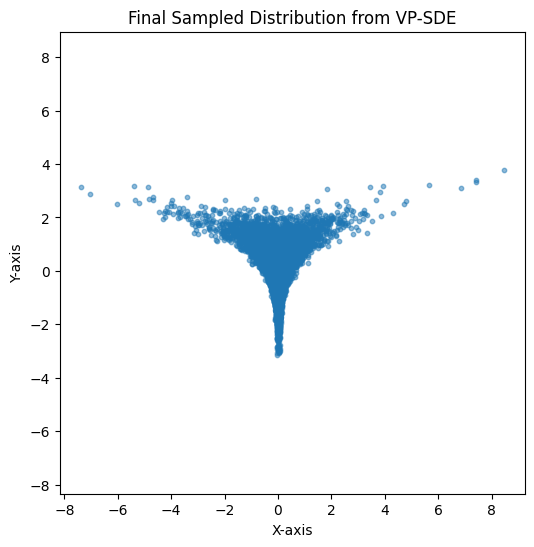

In [182]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

def vp_ode_sample(model,x_T, timesteps, beta_min=0.1, beta_max=20.0, save_trajectory=True):
    """
    Implements the reverse sampling process for VP-SDE using Euler-Maruyama method.
    
    Args:
        x_T: Final noisy sample (torch.Tensor) of shape (N, D)
        timesteps: Number of diffusion steps (int)
        beta_min: Minimum beta value (float)
        beta_max: Maximum beta value (float)
        save_trajectory: Whether to save and return the sampling trajectory (bool)
    
    Returns:
        x_0: Recovered data sample (torch.Tensor)
        trajectory: List of intermediate states (if save_trajectory=True)
    """
    dt = 1.0 / timesteps  # Time step for numerical integration
    x_t = x_T.clone()
    trajectory = [x_t.clone().cpu().numpy()] if save_trajectory else None
    model  = model.eval()
    for t_index in reversed(range(1,timesteps)):
        t = t_index * dt
        print("t",t, end="\r")
        # 计算 α(t) 和 σ(t)
        integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
        integral = torch.Tensor([integral])
        alpha = torch.exp(-integral)
        
        beta_t = beta_min +  (beta_max - beta_min) * t
        beta_t = torch.Tensor([beta_t])
        
        with torch.no_grad():
            t_input = torch.Tensor([t]*len(x_t)).to(device).unsqueeze(-1)
            # print('x_t',x_t.shape, t_input.shape)
            noise_pred = model(x_t.to(device),t_input)
            if  not torch.isfinite(noise_pred).all():
                print('score_function got nan',score_function,t_index)
                raise 
            score_function = - noise_pred.cpu() / torch.sqrt(1-alpha)
        s_theta  = score_function.cpu()
        # Reverse SDE Euler-Maruyama step
        # x_t = x_t +1/2 * beta_t *( x_t +2* s_theta)* dt # dritf term            
        # x_t += torch.sqrt(beta_t) * torch.randn_like(x_t) * math.sqrt(dt) # diffusion term
        x_t = x_t +1/2 * beta_t *( x_t + s_theta)* dt 
        if  not torch.isfinite(x_t).all():
            print("xt got infinite", t_index, x_t[:2],torch.sqrt(1-alpha))
            
        if save_trajectory:
            trajectory.append(x_t.clone().cpu().numpy())

    return x_t, trajectory if save_trajectory else None

# Set parameters
timesteps = 1500
num_samples = 20000
dim = 2  # 2D distribution for visualization
x_T = torch.randn(num_samples, dim)  # Sample from Gaussian prior (standard normal)

# Perform VP-SDE sampling
x_0, trajectory = vp_ode_sample(model, x_T, timesteps)

# Convert trajectory to numpy for plotting
trajectory_np = np.array(trajectory)  # Shape: (timesteps, num_samples, dim)

# Plot final distribution shape
plt.figure(figsize=(6, 6))
plt.scatter(x_0[:, 0].numpy(), x_0[:, 1].numpy(), alpha=0.5, s=10)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 

plt.show()



In [183]:
make_animation(trajectory_np, filename="vp_ode_sampling.gif")

In [151]:
x_0

tensor([[-inf, -inf],
        [inf, -inf],
        [-inf, inf],
        ...,
        [inf, inf],
        [-inf, inf],
        [inf, -inf]])

# Langervin Sampling

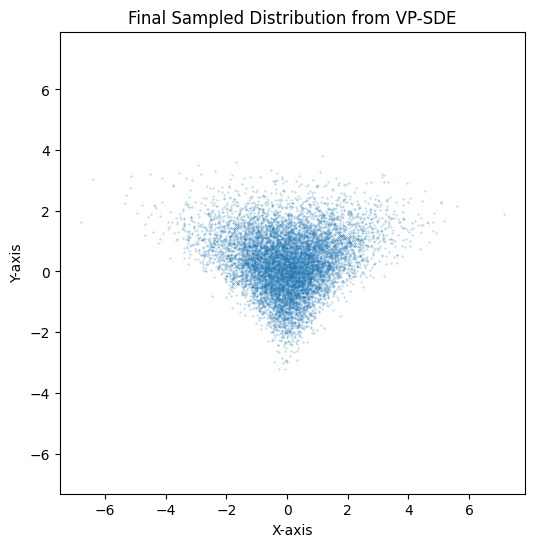

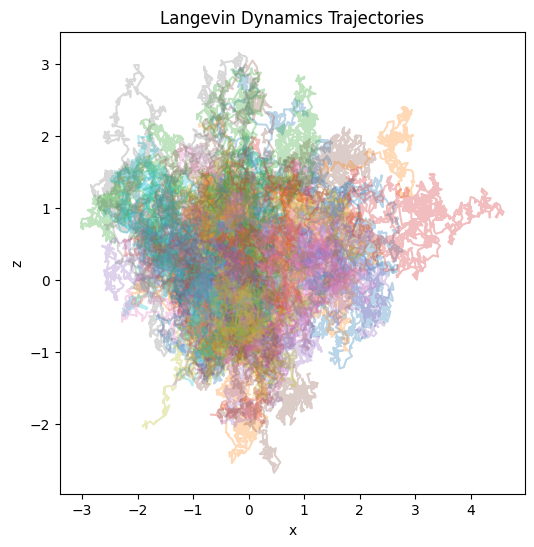

In [189]:
import torch
import matplotlib.pyplot as plt

def funnel_score(x, z):
    """Compute the score function (gradient of log-density) of the funnel distribution."""
    score_x = -x / torch.exp(z)
    score_z = -z + 0.5 * x**2 * torch.exp(-z)
    return torch.stack([score_x, score_z], dim=1)

def langevin_sampling_funnel(num_samples=10000, lr=0.001, num_steps=1500, noise_scale=0.001):
    """Sample from the funnel distribution using Langevin dynamics."""
    # Initialize samples from a normal distribution
    samples = torch.randn(num_samples, 2)
    trajectory = [samples.clone()]  # Store trajectory

    for _ in range(num_steps):
        x, z = samples[:, 0], samples[:, 1]
        score = funnel_score(x, z)
        samples = samples + lr * score + math.sqrt(2*noise_scale) * torch.randn_like(samples)
        trajectory.append(samples.clone())  # Store trajectory step

    return samples, trajectory

# Sample using Langevin dynamics
samples, trajectory = langevin_sampling_funnel()

# Convert trajectory to numpy for visualization
trajectory_np = [step.numpy() for step in trajectory]

# Plot final distribution
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=0.1)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal") 
plt.show()

# Plot trajectory of a few samples
num_plot_samples = 50
plt.figure(figsize=(6, 6))
for i in range(num_plot_samples):
    traj_x = [step[i, 0] for step in trajectory_np]
    traj_z = [step[i, 1] for step in trajectory_np]
    plt.plot(traj_x, traj_z, alpha=0.3)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Langevin Dynamics Trajectories")
plt.show()


In [191]:
trajectory[0].shape

torch.Size([10000, 2])

In [194]:
img_file='/mnt/nas/public2/lilong/repos/generative-ai-start-to-surrender/docs/images/langervin_annitation.gif'
make_animation(trajectory_np, filename=img_file)